# Sensor Data Notebook

This notebook is for the first data operations:
- Are there any outliers? How does the data compare to common thresholds? Lets Plot!
- Attach the sky view factor to the data and provide metadata on the calculations
- Fill in remaining sensor matadata
- Explore meteo Variables from Grenchen Airport station
- Calculate difference between sensor and reference stations
- Explore hourly difference between urban/rural/reference stations

In [1]:
#import data and libraries
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset('data/pilot_data.nc')
dsm = xr.open_dataset('data/pilot_data_meteo.nc')

First, open the data set and look at the variables

In [2]:
ds

<xarray.Dataset>
Dimensions:    (time: 9216, sensor: 8)
Coordinates:
  * time       (time) datetime64[ns] 2022-07-09 ... 2022-09-10T23:50:00
  * sensor     (sensor) object '201' '202' '203' '204' '205' '206' '207' 'ref'
Data variables:
    temp       (sensor, time) float64 ...
    temp_diff  (sensor, time) float64 ...

Then we can plot the data and look for outliers. There do not seem to be any.

The maximum and minimum temperature in the series is 38.046 and 9.8 respectively


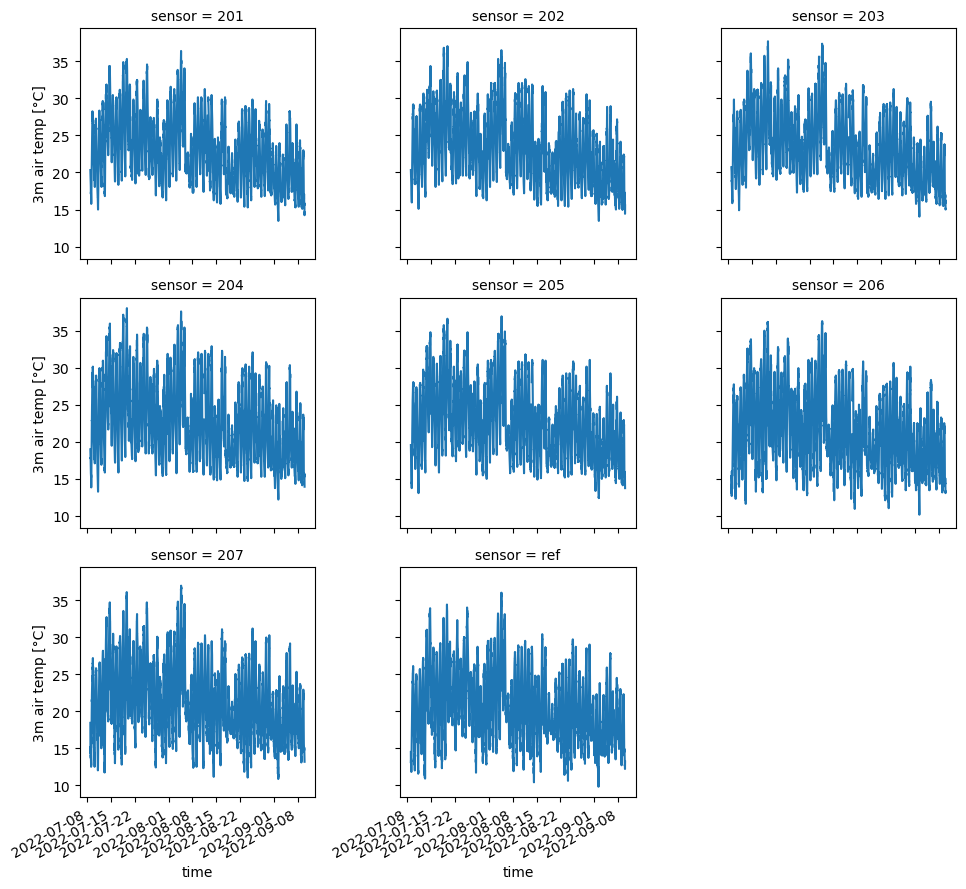

In [3]:
print(f'The maximum and minimum temperature in the series is {float(ds.temp.max())} and {float(ds.temp.min())} respectively')
ds.temp.plot(col='sensor', col_wrap = 3)
plt.show()

We can resample the data to daily values and take the minimum (or maximum) of these values. This plotted next so we can see day by data how the max and min is evolving.

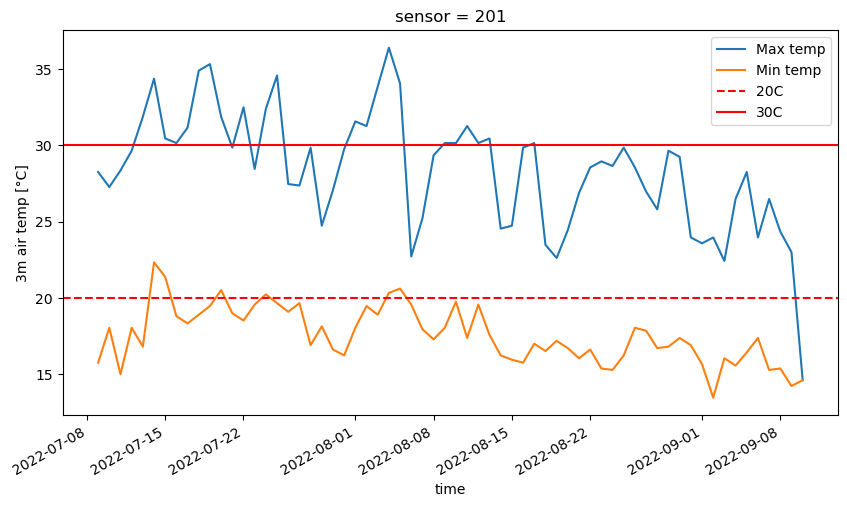

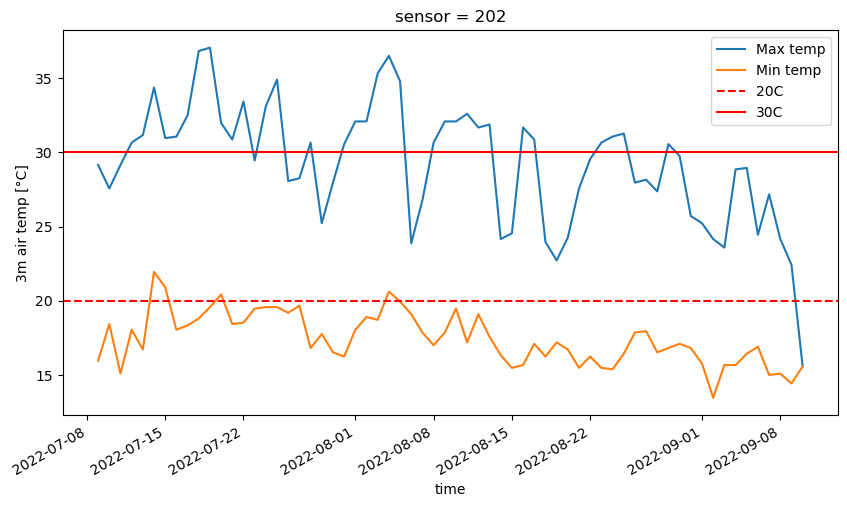

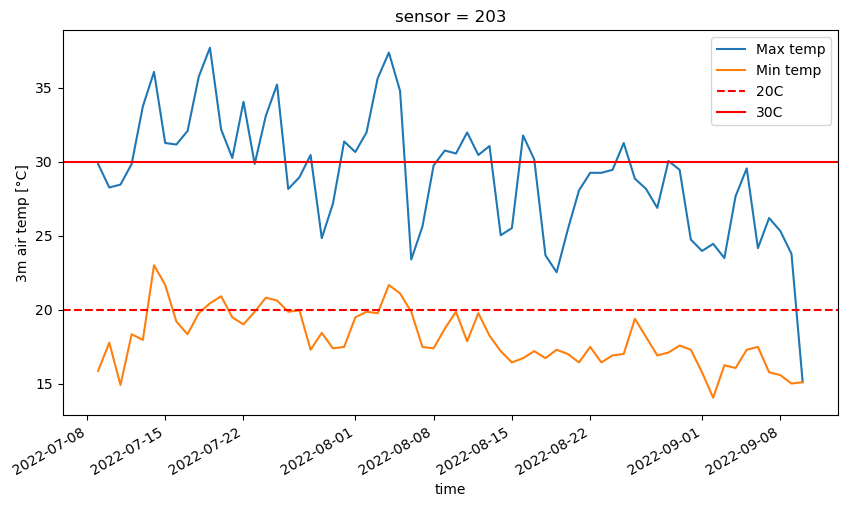

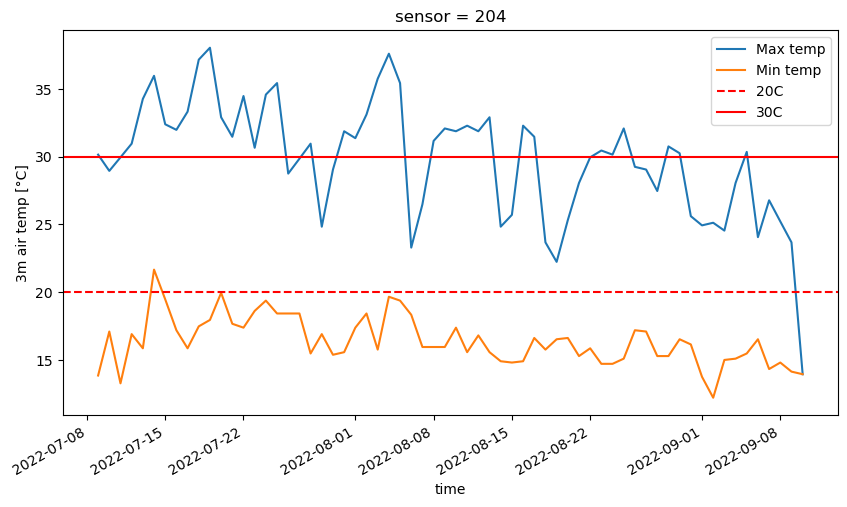

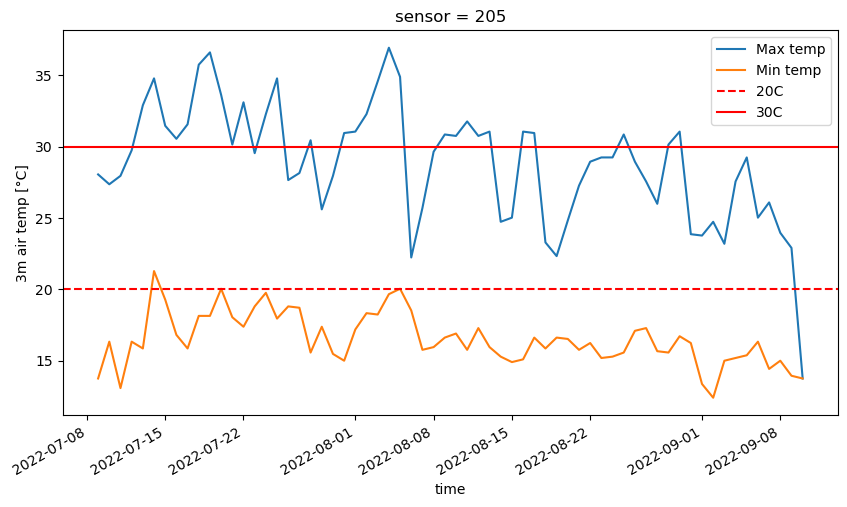

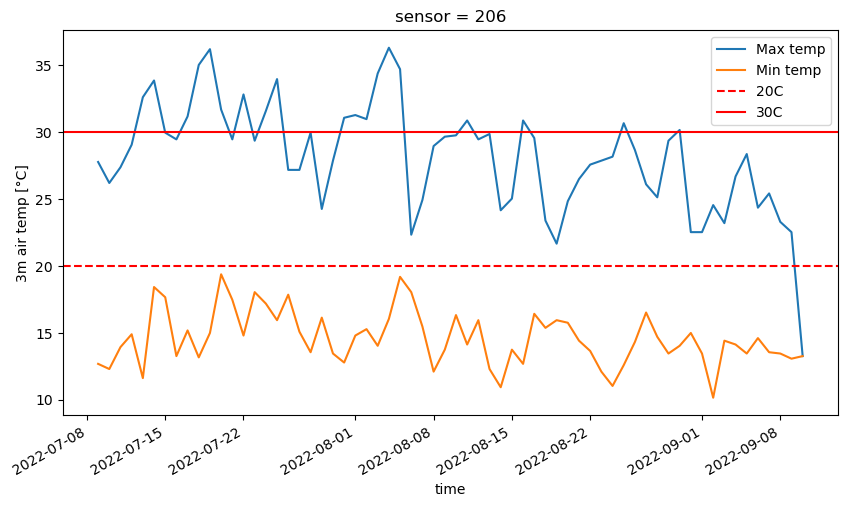

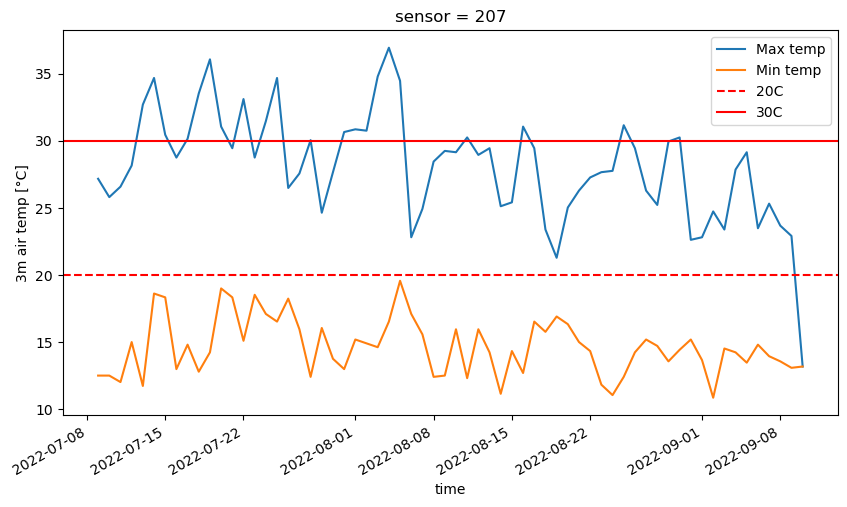

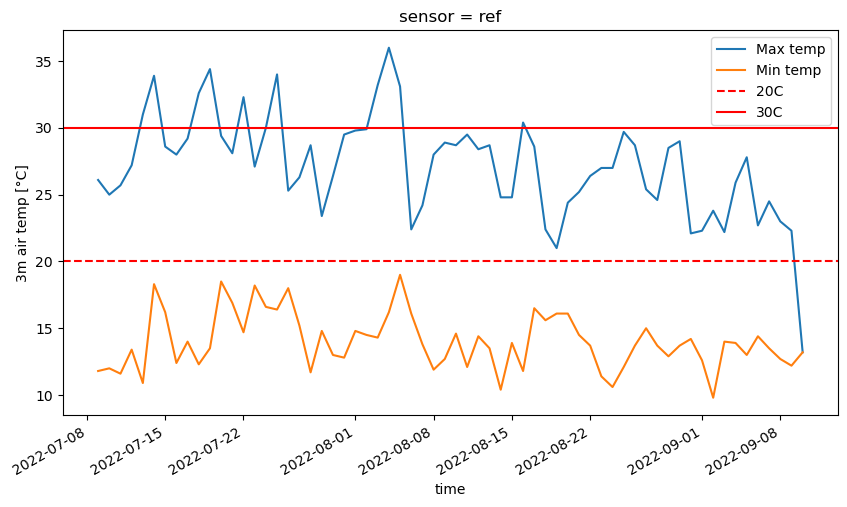

In [4]:
sensors = ds.sensor.values # get list of sensors

max_temp = ds.temp.resample(time='1D').max(dim='time') # find daily max
min_temp = ds.temp.resample(time='1D').min(dim='time') # find daily min

for sensor in sensors:
    fig, ax = plt.subplots(figsize=(10,5))
    max_temp.sel(sensor=sensor).plot(ax=ax, label='Max temp') # plot the max
    min_temp.sel(sensor=sensor).plot(ax=ax, label='Min temp') # plot the min
    ax.axhline(y=20, color='r', linestyle='--', label='20C')  # Adds a red dashed line at y=20
    ax.axhline(y=30, color='r', linestyle='-', label='30C')  # Adds a red solid line at y=30
    ax.legend()
    plt.show()


## Calcuating Temperature Difference From Reference

...

In [5]:
# add code from pilot_data.py script

## Attaching sky view factors

Lets attach the sky view factors that were previously calculated to the data. Since the Sky View Factors do not change over time for our purpose, they will be appended to the dataset on the 'sensor dimension' using the dictionary that we saved as a csv last time. Using Pytho's built-in csv reader, we can load the load the data:

In [6]:
import csv
import numpy as np

# Create an empty dictionary to store the data
data_dict = {}

# Open the CSV file for reading
with open('output.csv', 'r') as f:
    # Create a CSV reader
    reader = csv.reader(f)
    next(reader)
    # Loop over the rows in the file
    for row in reader:
        # Each row is a list of strings. We're assuming the first column is the key and the second column is the value.
        key = row[0]
        value = row[1]
        # Convert the value to float before storing in the dictionary
        data_dict[key] = float(value)
{k: np.round(v,2) for k,v in data_dict.items()}

{'201': 0.63,
 '202': 0.24,
 '203': 0.14,
 '204': 0.85,
 '205': 0.98,
 '206': 0.69,
 '207': 0.55}

And then we attach it to the xarray dataset

In [7]:
# now turn these into xarray format
svf_da = xr.DataArray(list(data_dict.values()), dims=["sensor"], coords=[list(data_dict.keys())])

# open dataset to attach these values to
ds = xr.open_dataset('data/pilot_data.nc')

# assign values
ds['svf'] = svf_da

#invent data for reference (will just be nan otherwise)
ds.svf.loc[{'sensor':'ref'}] = 0.9892823

ds

<xarray.Dataset>
Dimensions:    (time: 9216, sensor: 8)
Coordinates:
  * time       (time) datetime64[ns] 2022-07-09 ... 2022-09-10T23:50:00
  * sensor     (sensor) object '201' '202' '203' '204' '205' '206' '207' 'ref'
Data variables:
    temp       (sensor, time) float64 ...
    temp_diff  (sensor, time) float64 ...
    svf        (sensor) float64 0.6329 0.2406 0.1447 ... 0.6907 0.5546 0.9893

Now set the metadata attributes, one of the strengths of Xarray datasets

In [8]:
ds['svf'].attrs['long_name'] = 'Sky View Factor'
ds['svf'].attrs['units'] = 'fraction (unitless)'
ds['svf'].attrs['description'] = 'The proportion of the visible sky at the sensor location.'
ds['svf'].attrs['details'] = 'Anything you want to say about the calculations that people should be aware of!'

## Attaching Other metadata

In [9]:
# check the meta data existing...

# code # to # come

## Meteorological variables
The Swissmeteo station at grenchen airport provides a number of variables, some of which are included in the dataset below.

In [10]:
dsm

<xarray.Dataset>
Dimensions:  (time: 9216)
Coordinates:
  * time     (time) datetime64[ns] 2022-07-09 ... 2022-09-10T23:50:00
Data variables:
    abs_hum  (time) float64 ...
    radi     (time) int64 ...
    temp     (time) float64 ...
    prec_t   (time) float64 ...
    wind     (time) float64 ...

We can plot in the exact same way, here we can take a look at daily cumululative precipitation.

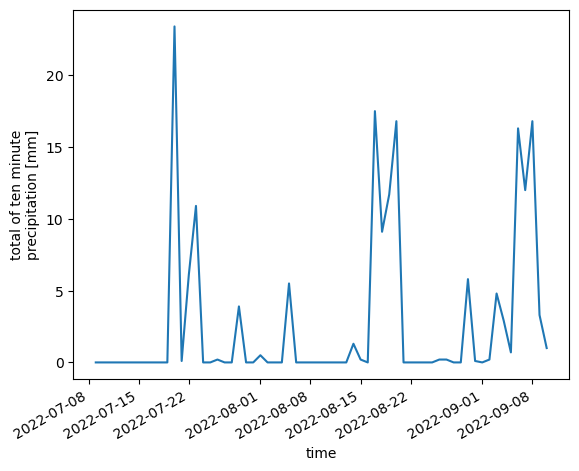

In [11]:
dsm.prec_t.resample(time = '1D').sum().plot()
plt.show()